# Altermagnetic superconductors

In [1]:
import kwant
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from tqdm.notebook import tqdm

from plot_tools import complex_plot

In [2]:
def add_tl_label(ax, text):
    ax.text(
        0.02,
        0.98,
        text,
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=dict(facecolor=[1, 1, 1, 0.90], edgecolor="none", pad=0.25),
    )

In [3]:
#plt.style.use("plot_style.mplstyle")

In [4]:
# Pauli matrices
s0 = np.array([[1.0, 0.0], [0.0, 1.0]])
sx = np.array([[0.0, 1.0], [1.0, 0.0]])
sy = np.array([[0.0, -1j], [1j, 0.0]])
sz = np.array([[1.0, 0.0], [0.0, -1.0]])

# Kron products
t0s0 = np.kron(s0, s0)
t0sx = np.kron(s0, sx)
t0sy = np.kron(s0, sy)
t0sz = np.kron(s0, sz)

txs0 = np.kron(sx, s0)
txsx = np.kron(sx, sx)
txsy = np.kron(sx, sy)
txsz = np.kron(sx, sz)

tys0 = np.kron(sy, s0)
tysx = np.kron(sy, sx)
tysy = np.kron(sy, sy)
tysz = np.kron(sy, sz)

tzs0 = np.kron(sz, s0)
tzsx = np.kron(sz, sx)
tzsy = np.kron(sz, sy)
tzsz = np.kron(sz, sz)

In [5]:
def bulk_amsc_system(Nx, Ny, t, t_so, t_am, V, Delta, theta, hx, hy, hz, periodic_bc):
    """
    Create a Kwant system for a bulk altermagnetic superconductor.

    Args:
        Nx (int): Number of sites in the x-direction.
        Ny (int): Number of sites in the y-direction.
        t (float): Hopping amplitude.
        t_so (float): Spin-orbit hopping amplitude.
        t_am (float): Altermagnetic hopping amplitude.
        V (float): Potential landscape.
        Delta (callable): Function describing the superconducting gap as a function of position (x, y).
        theta (callable): Function describing the superconducting phase as a function of position (x, y).
        hx (callable): Function describing the x-component of the magnetic field as a function of position (x, y).
        hy (callable): Function describing the y-component of the magnetic field as a function of position (x, y).
        hz (callable): Function describing the z-component of the magnetic field as a function of position (x, y).
        periodic_bc (bool): Wether using periodic boundary conditions.
        
    Returns:
        kwant.system.System: A Kwant system for the given parameters.
    """
    
    # Create a Kwant lattice for a square system with 4 orbitals.
    lat = kwant.lattice.square(a=1, norbs=4)
    syst = kwant.Builder()

    # Domain definition
    def square(pos):
        (x, y) = pos
        return (abs(x) <= Nx // 2) * (abs(y) <= Ny // 2)

    # Onsite Hamiltonian element
    def onsite(site1):
        (x, y) = site1.pos
        return (
            (4 * t + V(x, y)) * tzs0
            - hx(x, y) * t0sx
            - hy(x, y) * t0sy
            - hz(x, y) * t0sz
            + txs0 * Delta(x, y) * np.cos(theta(x, y))
            - tys0 * Delta(x, y) * np.sin(theta(x, y))
        )

    # Hopping Hamiltonian elements
    def hopx(site1, site2):
        return -t * tzs0 + t_am * t0sz - 1j * t_so * tzsy

    def hopy(site1, site2):
        return -t * tzs0 - t_am * t0sz + 1j * t_so * tzsx

    # Define the on-site, x-hopping, and y-hopping terms for the system.
    syst[lat.shape(square, (0, 0))] = onsite
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = hopx
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = hopy

    # Apply periodic BC
    if periodic_bc:
        for i in range(-(Ny // 2), Ny // 2 + 1):
            syst[lat(Nx // 2, i), lat(-(Nx // 2), i)] = hopx

        for i in range(-(Nx // 2), Nx // 2 + 1):
            syst[lat(i, Ny // 2), lat(i, -(Ny // 2))] = hopy

    return syst, lat


def impurity_system(
    Nx,
    Ny,
    t,
    t_so,
    t_am,
    V,
    Delta,
    theta,
    hx,
    hy,
    hz,
    periodic_bc,
    t_prime,
    t_am_prime,
    t_so_prime,
    ):

    """
    Create a Kwant system for an altermagnetic superconductor with an impurity in the center.

    Args:
        Nx (int): Number of sites in the x-direction.
        Ny (int): Number of sites in the y-direction.
        t (float): Hopping amplitude.
        t_so (float): Spin-orbit hopping amplitude.
        t_am (float): Altermagnetic hopping amplitude.
        V (float): Potential landscape.
        Delta (callable): Function describing the superconducting gap as a function of position (x, y).
        theta (callable): Function describing the superconducting phase as a function of position (x, y).
        hx (callable): Function describing the x-component of the magnetic field as a function of position (x, y).
        hy (callable): Function describing the y-component of the magnetic field as a function of position (x, y).
        hz (callable): Function describing the z-component of the magnetic field as a function of position (x, y).
        periodic_bc (bool): Wether using periodic boundary conditions.

        t_prime (float): Hopping amplitude for the impurity.
        t_so_prime  (float): Spin-orbit hopping amplitude for the impurity.
        t_am_prime  (float): Altermagnetic hopping amplitude for the impurity.

    Returns:
        kwant.system.System: A Kwant system for the given parameters.
    """


    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    # Changing the hopping around the impurity
    syst[lat(0, 0), lat(-1, 0)] = -t_prime * tzs0 + t_am_prime * t0sz - 1j * t_so_prime * tzsy
    syst[lat(+1, 0), lat(0, 0)] = -t_prime * tzs0 + t_am_prime * t0sz - 1j * t_so_prime * tzsy

    syst[lat(0, +1), lat(0, 0)] = -t_prime * tzs0 - t_am_prime * t0sz + 1j * t_so_prime * tzsx
    syst[lat(0, 0), lat(0, -1)] = -t_prime * tzs0 - t_am_prime * t0sz + 1j * t_so_prime * tzsx
    

    return syst, lat


# System Setup

In [6]:
periodic_bc = False

Nx = 51
Ny = 51

x_ax = np.linspace(-(Nx // 2), (Nx // 2), Nx)
y_ax = np.linspace(-(Ny // 2), (Ny // 2), Ny)
x, y = np.meshgrid(x_ax, y_ax)

t = 10
t_so = 0.0
t_am = 0.01

mu = 2 * t  # Midband
hz0 = 1e-9
hx0 = 0
hy0 = 0

s_imp = 2      # Impurity size
hx_imp = 0     # Impurity field
hy_imp = 0     # Impurity field
hz_imp = 0     # Impurity field
V_imp = -2 * t  # Impurity potential (negative = attractive)


# Fields definition
def V(x, y):
    r = np.sqrt(x**2 + y**2)
    return -mu + V_imp * np.exp(-(r**2) / s_imp**2)


def hx(x, y):
    r = np.sqrt(x**2 + y**2)
    return hx0 + hx_imp * np.exp(-(r**2) / s_imp**2)


def hy(x, y):
    r = np.sqrt(x**2 + y**2)
    return hy0 + hy_imp * np.exp(-(r**2) / s_imp**2)


def hz(x, y):
    r = np.sqrt(x**2 + y**2)
    return hz0 + hz_imp * np.exp(-(r**2) / s_imp**2)


# Temperature
T = 0.001

# Select the number of eigenvalues to calculate (it will set the energy cutoff)
N = 50

# Self consistency loops
Nloops = 0

# Sparse or dense diagonalization
sparse=True

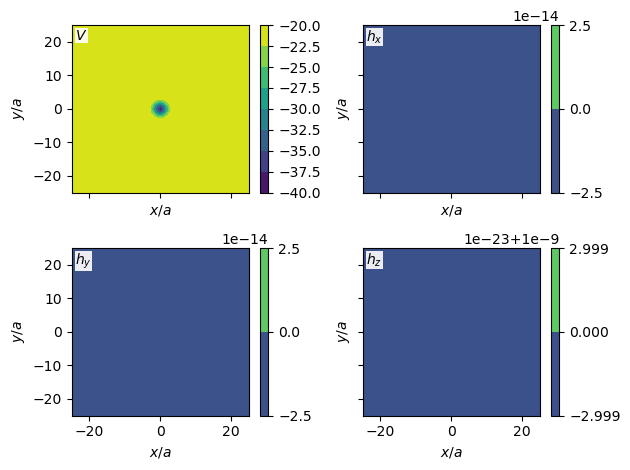

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)

# Plot for V(x, y)
im1 = axs[0, 0].contourf(x, y, V(x, y))
add_tl_label(axs[0, 0], r"$V$",)
axs[0, 0].set_xlabel(r"$x/a$")
axs[0, 0].set_ylabel(r"$y/a$")

# Plot for hx(x, y)
im2 = axs[0, 1].contourf(x, y, hx(x, y))
add_tl_label(axs[0, 1], r"$h_x$")
axs[0, 1].set_xlabel(r"$x/a$")
axs[0, 1].set_ylabel(r"$y/a$")

# Plot for hy(x, y)
im3 = axs[1, 0].contourf(x, y, hy(x, y))
add_tl_label(axs[1, 0], r"$h_y$")
axs[1, 0].set_xlabel(r"$x/a$")
axs[1, 0].set_ylabel(r"$y/a$")

# Plot for hz(x, y)
im4 = axs[1, 1].contourf(x, y, hz(x, y))
add_tl_label(axs[1, 1], r"$h_z$")
axs[1, 1].set_xlabel(r"$x/a$")
axs[1, 1].set_ylabel(r"$y/a$")

fig.colorbar(im1) 
fig.colorbar(im2) 
fig.colorbar(im3) 
fig.colorbar(im4) 

fig.tight_layout()

In [8]:
# Amplitude and phase of the order parameter

## Initial value for Delta (will be used to determine g)
Delta_init = 1

def Delta(x, y):
    delta = Delta_init * (1 - np.exp(-np.sqrt(x**2 + y**2) / 0.0001))
    #   delta = Delta_init * np.ones_like(x)
    return delta


def theta(x, y):
    return 0*np.arctan2(y, x)  # np.zeros_like(x)

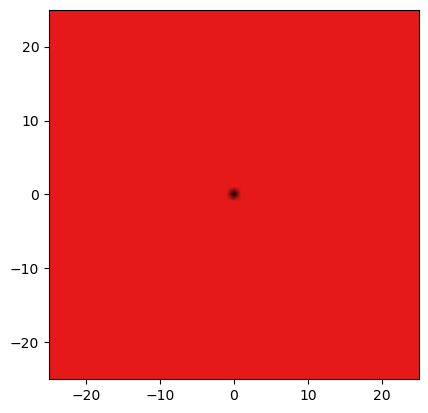

In [9]:
# Show the order parameter
fig, ax, im = complex_plot(x, y, Delta(x, y) * np.exp(1j * theta(x, y)))

In [10]:
    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )
    

In [11]:
# Bulk system
# def create_system(Delta, theta):
#     syst, lat = bulk_amsc_system(
#         Nx=Nx,
#         Ny=Ny,
#         t=t,
#         t_so=t_so,
#         t_am=t_am,
#         V=V,
#         Delta=Delta,
#         theta=theta,
#         hx=hx,
#         hy=hy,
#         hz=hz,
#         periodic_bc=periodic_bc,
#     )
    
#     return syst.finalized()



## IMPURITY
t_prime = 0.2 * t
t_so_prime = 0.2 * t_so
t_am_prime = 0.2 * t_am

def create_system(Delta, theta):
    syst, lat = impurity_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
        t_prime = t_prime,
        t_so_prime = t_so_prime,
        t_am_prime = t_am_prime
    )    
    
    return syst.finalized()


In [12]:
fsyst = create_system(Delta, theta)

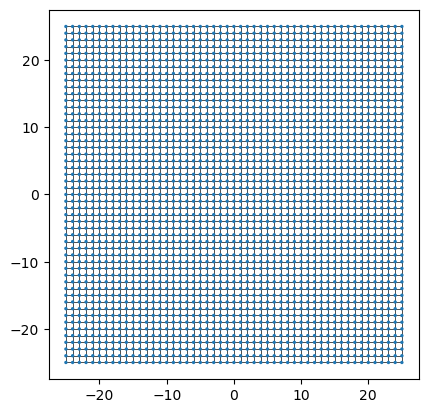

In [13]:
kwant.plot(fsyst);

In [14]:
# Quasiparticle density
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

# Electric charge
tzs0_op = kwant.operator.Density(fsyst, onsite=tzs0, sum=False)

# Spin
tzsx_op = kwant.operator.Density(fsyst, onsite=tzsx, sum=False)
tzsy_op = kwant.operator.Density(fsyst, onsite=tzsy, sum=False)
tzsz_op = kwant.operator.Density(fsyst, onsite=tzsz, sum=False)

# Singlet correlations
txs0_op = kwant.operator.Density(fsyst, onsite=txs0, sum=False)
tys0_op = kwant.operator.Density(fsyst, onsite=tys0, sum=False)

# Triplet correlations
txsx_op = kwant.operator.Density(fsyst, onsite=txsx, sum=False)
tysx_op = kwant.operator.Density(fsyst, onsite=tysx, sum=False)
txsy_op = kwant.operator.Density(fsyst, onsite=txsy, sum=False)
tysy_op = kwant.operator.Density(fsyst, onsite=tysy, sum=False)
txsz_op = kwant.operator.Density(fsyst, onsite=txsz, sum=False)
tysz_op = kwant.operator.Density(fsyst, onsite=tysz, sum=False)

# Currents
j_t0s0_op = kwant.operator.Current(fsyst, onsite=t0s0)
j_tzs0_op = kwant.operator.Current(fsyst, onsite=tzs0)
j_tzsz_op = kwant.operator.Current(fsyst, onsite=tzsz)

# Exact diagonalization

## Self-consistency

We first diagonalize the system once and by comparing the triplet correlations simulated with the original delta, we deterimne
the coupling constant $g$. Then we exectue the same diagonalization and update of the order parameter for$N_\mathrm{loops}$ times keeping $g$ fixed.

In [15]:
%%time

if sparse==True:
    ws, vs = sla.eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

else:
    ws, vs = la.eigh(fsyst.hamiltonian_submatrix())
    N = 4*Nx*Ny
    
sort_idxs = np.argsort(ws)
vs = vs[:, sort_idxs]
ws = ws[sort_idxs]

CPU times: user 31.1 s, sys: 351 ms, total: 31.5 s
Wall time: 3.64 s


In [16]:
print(f"The energy cutoff is {ws[-1]:5.3f}")

The energy cutoff is 1.022


In [17]:
txs0_ev = np.zeros((N, Nx * Ny))
tys0_ev = np.zeros((N, Nx * Ny))
for i in range(N):
    txs0_ev[i] = txs0_op(vs[:, i])
    tys0_ev[i] = tys0_op(vs[:, i])
    
Fx = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T)))
Fy = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T)))

g = Delta_init / np.mean(np.sqrt(Fx**2 + Fy**2))

Delta_n = g * np.sqrt(Fx**2 + Fy**2)
theta_n = np.arctan2(Fy, Fx)

print(f"The coupling constant is {g:5.3f}")

The coupling constant is 53.391


In [18]:
diff = np.mean((Delta_n.reshape(Nx, Ny) - Delta(x, y)) ** 2)
diff

8.532051083019605

In [19]:
Delta_interp = RegularGridInterpolator((x_ax, y_ax), Delta_n.reshape(Ny, Nx))
theta_interp = RegularGridInterpolator((x_ax, y_ax), theta_n.reshape(Ny, Nx))

Delta = lambda x, y: Delta_interp((x, y))
theta = lambda x, y: theta_interp((x, y))

In [20]:
for iter_number in range(Nloops):
    # Create a new system with the new order parameter
    fsyst = create_system(
        Delta=Delta,
        theta=theta,
    )

    # Diagonalize the sytem
    ws, vs = sla.eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=n_c, sigma=0)
    sort_idxs = np.argsort(ws)
    vs = vs[:, sort_idxs]
    ws = ws[sort_idxs]

    # Calculate correlation functions
    txs0_ev = np.zeros((N, Nx * Ny))
    tys0_ev = np.zeros((N, Nx * Ny))
    for i in range(N):
        txs0_ev[i] = txs0_op(vs[:, i])
        tys0_ev[i] = tys0_op(vs[:, i])

    Fx = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T)))
    Fy = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T)))

    # Calculate the order parameter
    Delta_n = g * np.sqrt(Fx**2 + Fy**2)
    theta_n = np.arctan2(Fy, Fx)

    diff = np.mean((Delta_n.reshape(Nx, Ny) - Delta(x, y)) ** 2)
    print(f"Iteration {iter_number}, the average error is: {diff:5f}")

    # Create the new interpolation functions
    Delta_interp = RegularGridInterpolator((x_ax, y_ax), Delta_n.reshape(Ny, Nx))
    theta_interp = RegularGridInterpolator((x_ax, y_ax), theta_n.reshape(Ny, Nx))

    # Update the order parameter
    Delta = lambda x, y: Delta_interp((x, y))
    theta = lambda x, y: theta_interp((x, y))

## Analysis of anomalous correlations

In [21]:
# Calculate correlation functions
txs0_ev = np.zeros((N, Nx * Ny))
tys0_ev = np.zeros((N, Nx * Ny))
txsx_ev = np.zeros((N, Nx * Ny))
tysx_ev = np.zeros((N, Nx * Ny))
txsy_ev = np.zeros((N, Nx * Ny))
tysy_ev = np.zeros((N, Nx * Ny))
txsz_ev = np.zeros((N, Nx * Ny))
tysz_ev = np.zeros((N, Nx * Ny))

for i in range(N):
    txs0_ev[i] = txs0_op(vs[:, i])
    tys0_ev[i] = tys0_op(vs[:, i])
    
    txsx_ev[i] = txsx_op(vs[:, i])
    tysx_ev[i] = tysx_op(vs[:, i])
    
    txsy_ev[i] = txsy_op(vs[:, i])
    tysy_ev[i] = tysy_op(vs[:, i])
    
    txsz_ev[i] = txsz_op(vs[:, i])
    tysz_ev[i] = tysz_op(vs[:, i])

F0_re = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
F0_im = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fx_re = np.einsum("ni, n -> i", txsx_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fx_im = np.einsum("ni, n -> i", tysx_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fy_re = np.einsum("ni, n -> i", txsy_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fy_im = np.einsum("ni, n -> i", tysy_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fz_re = np.einsum("ni, n -> i", txsz_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fz_im = np.einsum("ni, n -> i", tysz_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)

F0_abs = np.sqrt(F0_re**2 + F0_im**2)
F0_theta = np.arctan2(F0_im, F0_re)
Fx_abs = np.sqrt(Fx_re**2 + Fx_im**2)
Fx_theta = np.arctan2(Fx_im, Fx_re)
Fy_abs = np.sqrt(Fy_re**2 + Fy_im**2)
Fy_theta = np.arctan2(Fy_im, Fy_re)
Fz_abs = np.sqrt(Fy_re**2 + Fy_im**2)
Fz_theta = np.arctan2(Fy_im, Fy_re)

In [22]:
F0_abs.max()

2.774368542290793

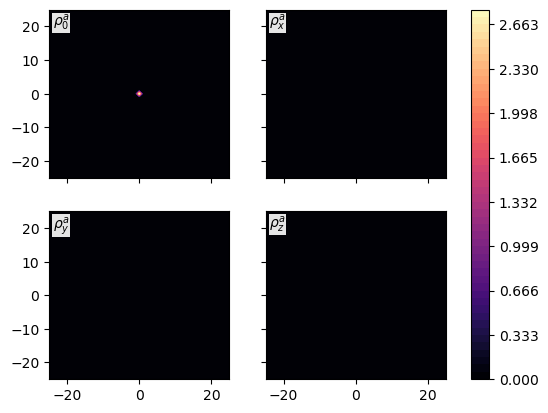

In [23]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
im00 = axs[0, 0].contourf(x, y, F0_abs, cmap="magma", levels=np.linspace(0, 1, 51)*F0_abs.max())
axs[0, 1].contourf(x, y, Fx_abs, cmap="magma", levels=np.linspace(0, 1, 51)*F0_abs.max())
axs[1, 0].contourf(x, y, Fy_abs, cmap="magma", levels=np.linspace(0, 1, 51)*F0_abs.max())
axs[1, 1].contourf(x, y, Fz_abs, cmap="magma", levels=np.linspace(0, 1, 51)*F0_abs.max())

cbar00 = fig.colorbar(im00, ax=axs, location="right")

add_tl_label(axs[0, 0], r"$\rho^a_0$")
add_tl_label(axs[0, 1], r"$\rho^a_x$")
add_tl_label(axs[1, 0], r"$\rho^a_y$")
add_tl_label(axs[1, 1], r"$\rho^a_z$")

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f38b5863a50>)

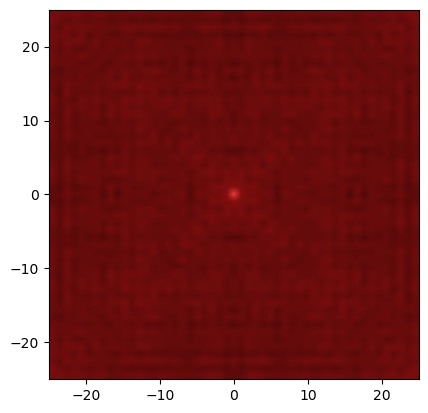

In [24]:
complex_plot(y, x, F0_abs * np.exp(1j * F0_theta))

## Single states analysis

In [25]:
# Select the subgap state to analyze
idx = len(ws) // 2

Text(0, 0.5, 'Energy')

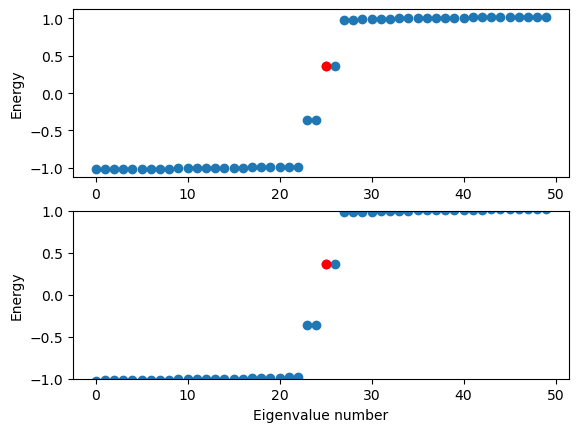

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

ax1.scatter(np.arange(len(ws)), ws)
ax1.scatter(idx, ws[idx], c="r")
ax1.set_ylabel(r"Energy")

ax2.scatter(np.arange(len(ws)), ws)
ax2.scatter(idx, ws[idx], c="r")
ax2.set_ylim(-Delta_init, Delta_init)
ax2.set_xlabel(r"Eigenvalue number")
ax2.set_ylabel(r"Energy")

In [27]:
# Calculate the densities
t0s0_d = t0s0_op(vs[:, idx])
tzs0_d = tzs0_op(vs[:, idx])
tzsz_d = tzsz_op(vs[:, idx])

txs0_d = txs0_op(vs[:, idx])
tys0_d = tys0_op(vs[:, idx])
txsx_d = txsx_op(vs[:, idx])
txsy_d = txsy_op(vs[:, idx])
txsz_d = txsz_op(vs[:, idx])
tysx_d = tysx_op(vs[:, idx])
tysy_d = tysy_op(vs[:, idx])
tysz_d = tysz_op(vs[:, idx])

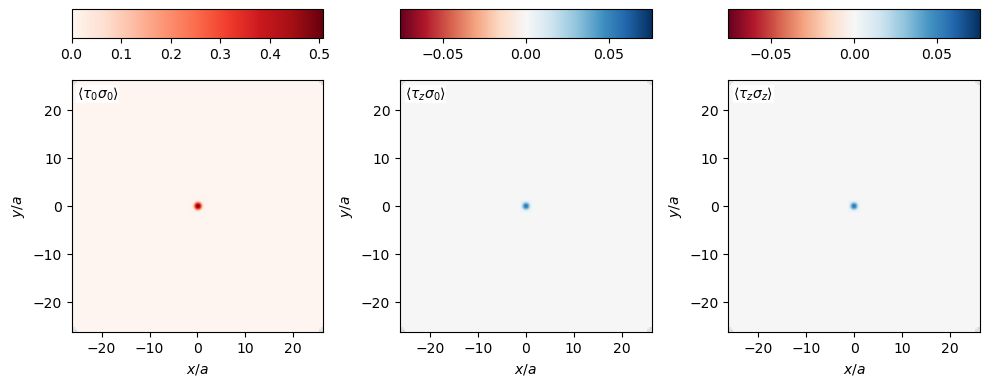

In [28]:
# Your existing code
fig = plt.figure(figsize=(10, 4))
gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[0.1, 1])

ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 2])

cax1 = plt.subplot(gs[0, 0])
cax2 = plt.subplot(gs[0, 1])
cax3 = plt.subplot(gs[0, 2])

im1 = kwant.plotter.density(fsyst, t0s0_d, ax=ax1, cmap="Reds", colorbar=cax1)
im2 = kwant.plotter.density(
    fsyst, tzs0_d, ax=ax2, cmap="RdBu", vmin=-abs(tzs0_d).max(), vmax=+abs(tzs0_d).max()
)
im3 = kwant.plotter.density(
    fsyst, tzsz_d, ax=ax3, cmap="RdBu", vmin=-abs(tzsz_d).max(), vmax=+abs(tzsz_d).max()
)

cbar1 = plt.colorbar(ax1.images[0], cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(ax2.images[0], cax=cax2, orientation="horizontal")
cbar3 = plt.colorbar(ax3.images[0], cax=cax3, orientation="horizontal")

add_tl_label(ax1, r"$\langle \tau_0 \sigma_0 \rangle$")
add_tl_label(ax2, r"$\langle \tau_z \sigma_0 \rangle$")
add_tl_label(ax3, r"$\langle \tau_z \sigma_z \rangle$")

ax1.set_xlabel(r"$x/a$")
ax2.set_xlabel(r"$x/a$")
ax3.set_xlabel(r"$x/a$")

ax1.set_ylabel(r"$y/a$")
ax2.set_ylabel(r"$y/a$")
ax3.set_ylabel(r"$y/a$")

fig.tight_layout()

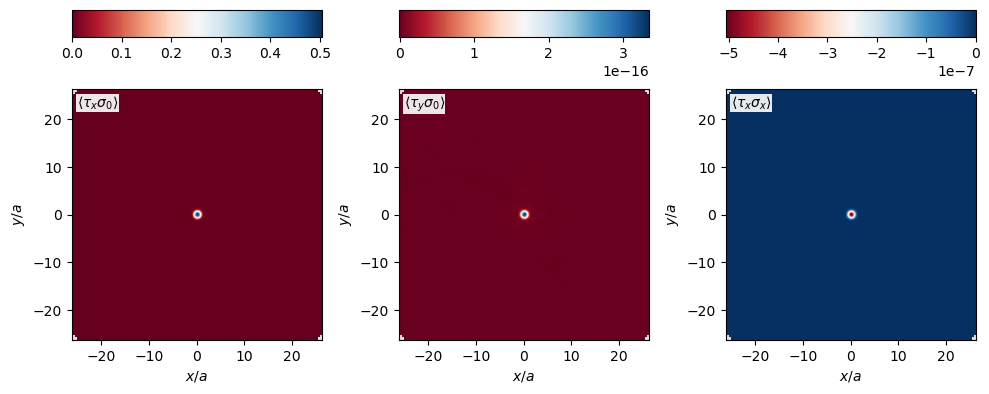

In [29]:
fig = plt.figure(figsize=(10, 4))
gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[0.1, 1])

ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 2])

cax1 = plt.subplot(gs[0, 0])
cax2 = plt.subplot(gs[0, 1])
cax3 = plt.subplot(gs[0, 2])

im1 = kwant.plotter.density(fsyst, txs0_d, ax=ax1, cmap="RdBu", colorbar=cax1)
im2 = kwant.plotter.density(fsyst, tys0_d, ax=ax2, cmap="RdBu")
im3 = kwant.plotter.density(fsyst, txsx_d, ax=ax3, cmap="RdBu")

cbar1 = plt.colorbar(ax1.images[0], cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(ax2.images[0], cax=cax2, orientation="horizontal")
cbar3 = plt.colorbar(ax3.images[0], cax=cax3, orientation="horizontal")

# Add labels to the top-left corner of each plot

add_tl_label(ax1, r"$\langle \tau_x \sigma_0 \rangle$")
add_tl_label(ax2, r"$\langle \tau_y \sigma_0 \rangle$")
add_tl_label(ax3, r"$\langle \tau_x \sigma_x \rangle$")

ax1.set_xlabel(r"$x/a$")
ax2.set_xlabel(r"$x/a$")
ax3.set_xlabel(r"$x/a$")

ax1.set_ylabel(r"$y/a$")
ax2.set_ylabel(r"$y/a$")
ax3.set_ylabel(r"$y/a$")

fig.tight_layout()


### Currents

In [30]:
j_t0s0 = j_t0s0_op(vs[:, idx])
j_tzs0 = j_tzs0_op(vs[:, idx])
j_tzsz = j_tzsz_op(vs[:, idx])

(-35.0, 35.0)

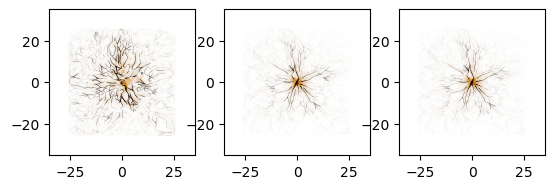

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

im1 = kwant.plotter.current(
    fsyst, j_t0s0, ax=ax1, colorbar=True, min_linewidth=0.1, max_linewidth=2
)
im2 = kwant.plotter.current(
    fsyst, j_tzs0, ax=ax2, colorbar=True, min_linewidth=0.1, max_linewidth=2
)
im3 = kwant.plotter.current(
    fsyst, j_tzsz, ax=ax3, colorbar=True, min_linewidth=0.1, max_linewidth=2
)

ax1.set_xlim(-35, 35)
ax1.set_ylim(-35, 35)

ax2.set_xlim(-35, 35)
ax2.set_ylim(-35, 35)

ax3.set_xlim(-35, 35)
ax3.set_ylim(-35, 35)

### Old code keeped only for reference

In [32]:
# Define the matrix elements of the magnetic quadrupole moment
def qxx(site):
    x, y = site.pos
    return tzsz * x**2


def qyy(site):
    x, y = site.pos
    return tzsz * y**2


def qxy(site):
    x, y = site.pos
    return tzsz * x * y


Qxx_op = kwant.operator.Density(fsyst, qxx, sum=True)
Qyy_op = kwant.operator.Density(fsyst, qyy, sum=True)
Qxy_op = kwant.operator.Density(fsyst, qxy, sum=True)

# Calculate the magnetic quadrupole moment
q_ev = np.array(
    [[Qxx_op(vs[:, idx]), Qxy_op(vs[:, idx])], [Qxy_op(vs[:, idx]), Qyy_op(vs[:, idx])]]
)

print(q_ev)

[[ 3.22153736e+00 -8.34401992e-15]
 [-8.34401992e-15  3.00478286e+00]]


In [33]:
Qyy = kwant.operator.Density(fsyst, qyy, sum=True)
Qyy(vs[:, idx])

3.004782861517717

In [34]:
Qxy = kwant.operator.Density(fsyst, qxy, sum=True)
Qxy(vs[:, idx])

-8.344019919448442e-15